## 2D SSN simulation ~  JAX IMPLEMENTATION

Changes required by JAX:
- jax.random vs numpy.random
- introduction of key variables to operate in random **
- np.chararray substituted -> created separate boolean array after locating indices in a list because jax doesnt support character arrays

In [1]:
#import numpy as np
import jax.numpy as np
from jax import jit
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
from jax import random

from SSN_classes_jax import SSN2DTopoV1_AMPAGABA_ONOFF
from util import GaborFilter, BW_Grating, find_A, create_gabor_filters

## Parameters for network initialisation

Resolution of SSN grid: 2.8125 pixels / degree

In [2]:
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms
    psi = 0.774
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

# with mm_scale=1, The following match "fixed_params" of  'Fig4_data-retinoHists-samples1000_TauCorr5_2020-04-11.json'
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

# Caleb's params for the full (with local) model:
Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141
sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09
conn_pars = dict(
    PERIODIC = False,
    p_local = [.4, 0.7], # [p_local_EE, p_local_IE],
    sigma_oris = 1000) # sigma_oris

make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*Js0)
s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])

## Initialise network

In [3]:
#Create network
ssn = SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars, grid_pars, conn_pars=conn_pars, J_2x2=J_2x2, s_2x2=s_2x2)

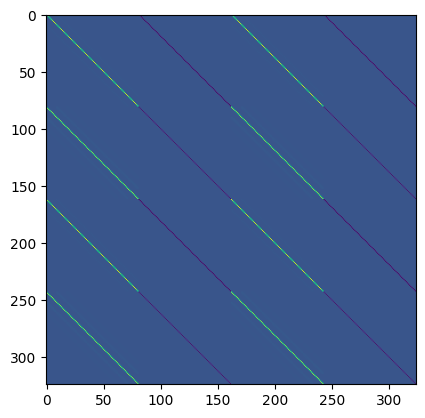

In [4]:
plt.imshow(ssn.W)


## Gabor function implementation

Parameters for Gabor filters

In [5]:
#Gabor parameters 
sigma_g= 0.5
k= np.pi/(6*sigma_g)
general_pars = dict(k=k, edge_deg=3.2,  degree_per_pixel=0.05) #parameters shared with input stimuli

#Create filters iterating through SSN neurons
SSN_filters, A =create_gabor_filters(ssn, sigma_g=sigma_g, conv_factor = grid_pars.magnif_factor, **general_pars)

Average A is 0.0008299059715404468


Iterate over neurons in SSN map

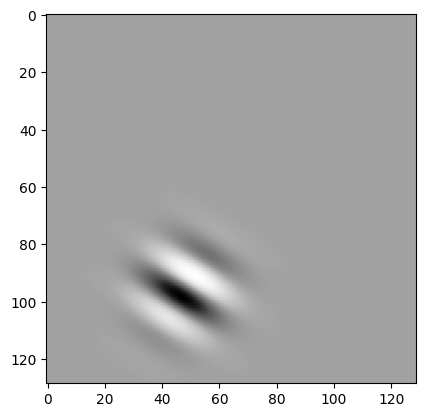

In [6]:
#Plot example filter
N_pixels=int(np.sqrt(SSN_filters.shape[1]))
plt.imshow(SSN_filters[2].reshape(N_pixels, N_pixels), cmap='Greys')

## Jia stimuli

Import stimuli. Parameters to specify:
- orientation -  in degrees from vertical (anti clockwise) - HAD TO ROTATE CREATION OF GABOR FILTERS!
- size - in pixels 227*227
- outer radius + inner radius - in degrees
- pixels per degree
- grating contrast - up to 1 (*100 in SSN code)
- snr - 0<= snr <= 1
- phase - in degrees
- spatial frequency - in degrees (need to multiply k* dx_i - dx_i in degrees/pixel)

In [7]:
#Stimuli parameters - all in degrees
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.99)
stimuli_pars.update(general_pars) #add size and resolution params from Gabor filters

#Create reference stimuli
ori_ref = 10
test_stimuli=BW_Grating(ori_deg = ori_ref, **stimuli_pars).BW_image()

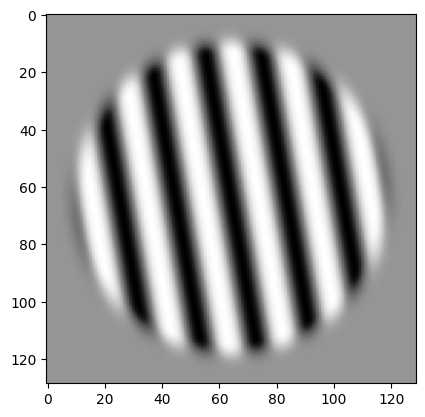

In [8]:
plt.imshow(test_stimuli, cmap='Greys')

### --->Finding average value of constant A over different Gabor filters

1. Select list of indices 

In [9]:
#OPTION 1 - choose random values for the orientation 
key = random.PRNGKey(90)
random_nums=random.choice(key, a=ssn.ori_map)
#indices=random_nums

#OPTION 2 - select angles in spread out range - selects every given number of angles
indices=np.sort(ssn.ori_map.ravel())

2. Run loop for different orientations - must centre Gabors at 0

In [10]:
#Find value of A using specified orientations
A, all_gabors, all_test_stimuli = find_A(return_all=True, sigma_g=sigma_g, conv_factor =grid_pars.magnif_factor, indices=indices, **general_pars)

Average A is 0.0008299059719974085


In [11]:
#check average value 
output_test=0
for i in range (len(all_gabors)):
    output_test+=np.matmul(all_gabors[i].ravel(), all_test_stimuli[i].ravel())*A
print(output_test/len(all_gabors))

100.0001


# -> Apply filters to stimuli

## Input to network

In [12]:
#Multiply all filters by the stimuli
output_gabor=np.matmul(SSN_filters, test_stimuli.ravel())*A

#Rectify input
SSN_input=np.maximum(0, output_gabor)

In [13]:
#Convergence parameters
dt = 1
xtol = 1e-5
Tmax = 600

#Find fixed point using input
r_init = np.zeros(SSN_input.shape[0])
r_fps, CONVG = ssn.fixed_point_r(SSN_input, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)


 Warning 1: reached Tmax=600, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = 0.1498628854751587,   xtol=1e-05.

Did not reach fixed point.


In [15]:
def response_plots(ori, SSN_filters, A, grating_pars, dt=1, x_tol= 1e-5, Tmax=600):
    '''
    Input given orientation and obtain response plots for all neuron types after reaching convergence
    '''

    #create stimulus at required orientation
    grating=BW_Grating(ori_deg=ori, **grating_pars,)
    test_stimuli=grating.BW_image()
    
    #multiply filters by stimuli
    output_gabor=np.matmul(SSN_filters, test_stimuli.ravel())*A
    
    #rectify output
    SSN_input=np.maximum(0, output_gabor)
    
    #Find fixed point using input
    r_init = np.zeros(SSN_input.shape[0])
    r_fps, CONVG = ssn.fixed_point_r(SSN_input, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)
    
    
    fig, ax = plt.subplots(2,2, figsize=(9,9))
    fig.subplots_adjust(hspace=0.2)

    ax[0,0].imshow(r_fps[0:ssn.Ne//2].reshape((9,9)))
    ax[0,0].set_title('E_ON')

    ax[0,1].imshow(r_fps[ssn.Ne//2:2*(ssn.Ne//2)].reshape((9,9)))
    ax[0,1].set_title('E_OFF')

    ax[1,0].imshow(r_fps[2*(ssn.Ne//2):3*(ssn.Ne//2)].reshape((9,9)))
    ax[1,0].set_title('I_ON')

    ax[1,1].imshow(r_fps[3*(ssn.Ne//2):].reshape((9,9)))
    ax[1,1].set_title('I_OFF')
    
    return r_fps


 Warning 1: reached Tmax=600, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = 0.09754876047372818,   xtol=1e-05.

Did not reach fixed point.


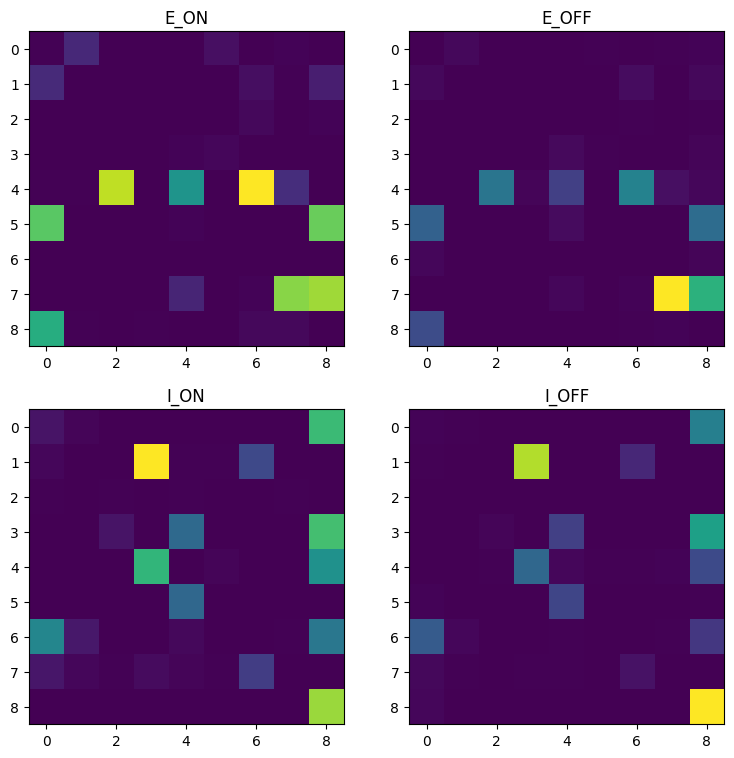

In [18]:
grating_pars=dict(outer_radius=3, inner_radius=2.5, degree_per_pixel=0.05, edge_deg=3.2, grating_contrast=0.9 ,k=k)
r1=response_plots(SSN_filters=SSN_filters, grating_pars=grating_pars, Tmax=400, dt=0.5, A=A, ori=10)


 Warning 1: reached Tmax=600, before convergence to fixed point.
       max(abs(dx./max(abs(xvec), 1.0))) = 0.09754876047372818,   xtol=1e-05.

Did not reach fixed point.


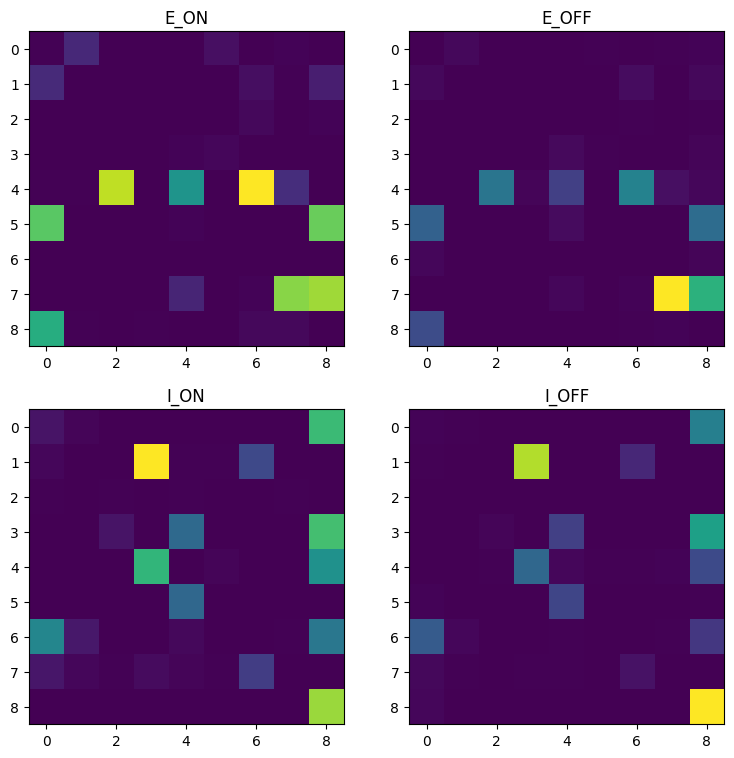

In [20]:
r2=response_plots(SSN_filters=SSN_filters, grating_pars=grating_pars, Tmax=800, A=A, ori=10)